Hierarchical sampling from clusters: 100%|██████████| 20/20 [00:00<00:00, 909.28it/s]
(1000, 2)


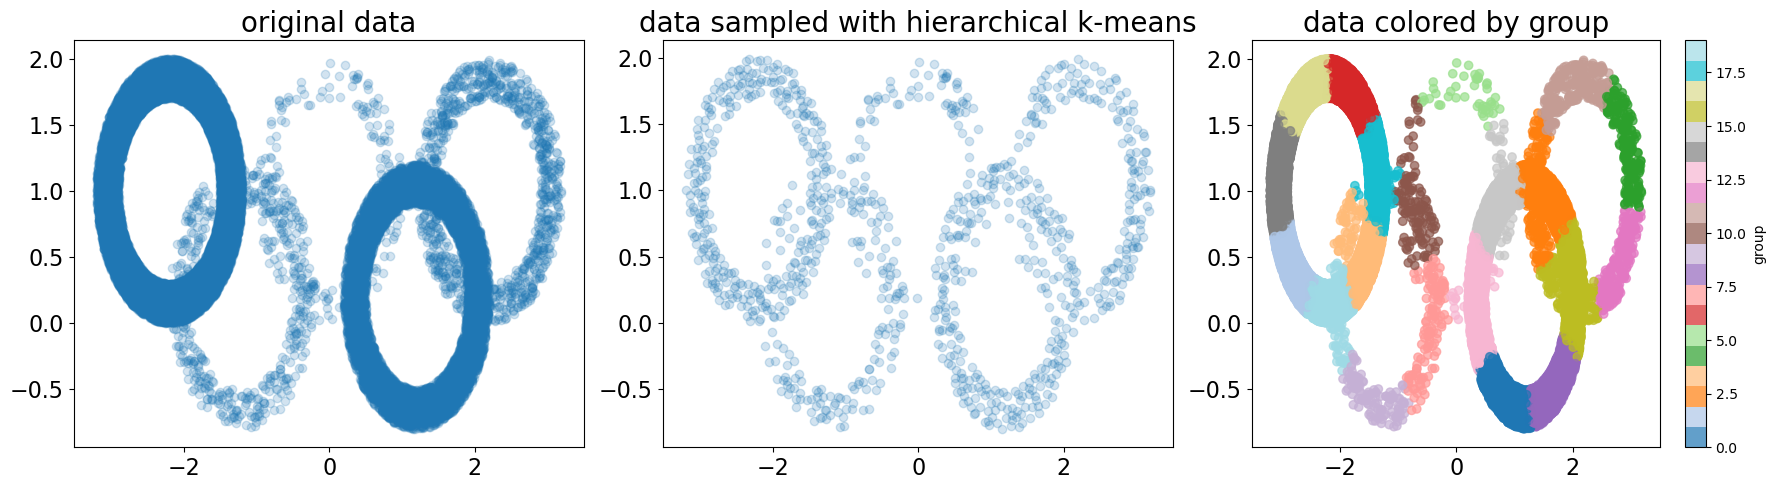

In [16]:
import torch
import numpy as np
from matplotlib import pyplot as plt

from src.datamodule.datacuration import (
  HierarchicalCluster,
  hierarchical_kmeans_gpu as hkmg,
  hierarchical_sampling,
  group_number
)

def make_ring(n, rmin, rmax):
    r = np.random.rand(n) * (rmax - rmin) + rmin
    alpha = np.random.rand(n) * 2 * np.pi
    return np.vstack([r * np.cos(alpha), r * np.sin(alpha)]).T

data = np.concatenate([
    make_ring(20000, 0.7, 1.0) + np.array([-2.2, 1.]),
    make_ring(200, 0.7, 1.0) + np.array([0., 1.]),
    make_ring(1000, 0.7, 1.0) + np.array([2.2, 1.]),
    make_ring(500, 0.7, 1.0) + np.array([-1.2, 0.2]),
    make_ring(8000, 0.7, 1.0) + np.array([1.2, 0.2]),
])

clusters = hkmg.hierarchical_kmeans_with_resampling(
  data=torch.tensor(data, device="cuda", dtype=torch.float32),
  n_clusters=[1000, 20],
  n_levels=2,
  sample_sizes=[15, 2],
  verbose=False,
)

cl = HierarchicalCluster.from_dict(clusters)
sampled_indices = hierarchical_sampling(cl, target_size=1000)
sampled_points = data[sampled_indices]
print(sampled_points.shape)

groups = group_number(clusters)

figh, figw = 1, 3  # Changed to add a third subplot
fig, axs = plt.subplots(figh, figw, figsize=(6 * figw, 5 * figh))
axs[0].scatter(data[:, 0], data[:, 1], alpha=0.2)
axs[0].set_title("original data", fontsize=20)
axs[0].tick_params(labelsize=16)
axs[1].scatter(sampled_points[:, 0], sampled_points[:, 1], alpha=0.2)
axs[1].set_title("data sampled with hierarchical k-means", fontsize=20)
axs[1].tick_params(labelsize=16)

# Third plot: color by group
scatter = axs[2].scatter(data[:, 0], data[:, 1], c=groups, cmap='tab20', alpha=0.7)
axs[2].set_title("data colored by group", fontsize=20)
axs[2].tick_params(labelsize=16)
plt.colorbar(scatter, ax=axs[2], label="group")

plt.tight_layout()
plt.show()